In [18]:
import torch
from torch import nn
from torch.optim import Adam
from torchvision import transforms, datasets
from torch.autograd import Variable
from IPython import display
import matplotlib.pyplot as plt
import logging
from torchvision.transforms import ToPILImage
from IPython.display import Image, display
import numpy as np
import scipy.misc

In [2]:
class Discriminator(torch.nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.conv1 = nn.Sequential(
            nn.Conv2d(
                in_channels=3, out_channels=128, kernel_size=4,
                stride=2, padding=1, bias=False
            ),
            nn.LeakyReLU(0.2, inplace=True)
        )
        self.conv2 = nn.Sequential(
            nn.Conv2d(
                in_channels=128, out_channels=256, kernel_size=4,
                stride=2, padding=1, bias=False
            ),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.2, inplace=True)
        )
        self.conv3 = nn.Sequential(
            nn.Conv2d(
                in_channels=256, out_channels=512, kernel_size=4,
                stride=2, padding=1, bias=False
            ),
            nn.BatchNorm2d(512),
            nn.LeakyReLU(0.2, inplace=True)
        )
        self.conv4 = nn.Sequential(
            nn.Conv2d(
                in_channels=512, out_channels=1024, kernel_size=4,
                stride=2, padding=1, bias=False
            ),
            nn.BatchNorm2d(1024),
            nn.LeakyReLU(0.2, inplace=True)
        )
        self.out = nn.Sequential(
            nn.Linear(1024 * 4 * 4, 1),
            nn.Sigmoid(),
        )

    def forward(self, x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = self.conv4(x)
        x = x.view(-1, 1024 * 4 * 4)
        x = self.out(x)
        return x

In [3]:
class Generator(torch.nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        self.linear = torch.nn.Linear(100, 1024 * 4 * 4)
        self.conv1 = nn.Sequential(
            nn.ConvTranspose2d(
                in_channels=1024, out_channels=512, kernel_size=4,
                stride=2, padding=1, bias=False
            ),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True)
        )
        self.conv2 = nn.Sequential(
            nn.ConvTranspose2d(
                in_channels=512, out_channels=256, kernel_size=4,
                stride=2, padding=1, bias=False
            ),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True)
        )
        self.conv3 = nn.Sequential(
            nn.ConvTranspose2d(
                in_channels=256, out_channels=128, kernel_size=4,
                stride=2, padding=1, bias=False
            ),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True)
        )
        self.conv4 = nn.Sequential(
            nn.ConvTranspose2d(
                in_channels=128, out_channels=3, kernel_size=4,
                stride=2, padding=1, bias=False
            )
        )
        self.out = torch.nn.Tanh()

    def forward(self, x):
        x = self.linear(x)
        x = x.view(x.shape[0], 1024, 4, 4)
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = self.conv4(x)
        return self.out(x)

In [4]:
compose = transforms.Compose(
    [transforms.Resize(64),
     transforms.ToTensor(),
     transforms.Normalize((.5, .5, .5), (.5, .5, .5))])
data = datasets.CIFAR10(root='./cifar', train=True, transform=compose, download=True)
batch_size = 128
data_loader = torch.utils.data.DataLoader(data, batch_size=batch_size, shuffle=True)
num_batches = len(data_loader)

def init_weights(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1 or classname.find('BatchNorm') != -1:
        m.weight.data.normal_(0.00, 0.02)

In [5]:
generator = Generator()
generator.apply(init_weights)

discriminator = Discriminator()
discriminator.apply(init_weights)

if torch.cuda.is_available():
    generator.cuda()
    discriminator.cuda()
    
optimizer_d = Adam(discriminator.parameters(), lr=0.0002, betas=(0.5, 0.999))
optimizer_g = Adam(generator.parameters(), lr=0.0002, betas=(0.5, 0.999))

loss = nn.BCELoss()

In [6]:

def real_data_target(size):
    data = Variable(torch.ones(size, 1))
    if torch.cuda.is_available():
        return data.cuda()
    return data


def fake_data_target(size):
    data = Variable(torch.zeros(size, 1))
    if torch.cuda.is_available():
        return data.cuda()
    return data
  
def rand_noise(size):
    noise = Variable(torch.randn(size, 100))
    if torch.cuda.is_available():
        return noise.cuda()
    return noise


def train_d(optimizer, x_real, x_fake):
    optimizer.zero_grad()

    y_real = discriminator(x_real)
    err_real = loss(y_real, real_data_target(x_real.size(0)))
    err_real.backward()

    y_fake = discriminator(x_fake)
    err_fake = loss(y_fake, fake_data_target(x_real.size(0)))
    err_fake.backward()

    optimizer.step()

    return err_real + err_fake, y_real, y_fake
  
def train_g(optimizer, x_fake):
    optimizer.zero_grad()
    y_pred = discriminator(x_fake)
    err = loss(y_pred, real_data_target(y_pred.size(0)))
    err.backward()
    optimizer.step()
    return err

n_epochs = 100
n_test_samples = 1
noise = rand_noise(n_test_samples)

In [ ]:
for epoch in range(n_epochs):
    for n_batch, (real_batch, _) in enumerate(data_loader):
        x_real = Variable(real_batch)
        if torch.cuda.is_available():
            x_real = x_real.cuda()
        x_fake = generator(rand_noise(x_real.size(0))).detach()
        d_err, d_pred_real, d_pred_fake = train_d(optimizer_d, x_real, x_fake)
        x_fake = generator(rand_noise(real_batch.size(0)))
        g_err = train_g(optimizer_g, x_fake)

        if (n_batch) % 100 == 0:
            # display.clear_output(True)
            image = generator(noise).data.cpu()
            %matplotlib inline
            # image = Image(ToPILImage(image))
            display(image)
            print('Epoch %d/%d, d_err: %.10f g_err: %.10f' % (
            epoch, n_epochs, d_err, g_err))

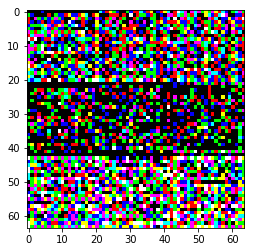

In [32]:
image = generator(noise).data.cpu()
npimg = image.numpy()
plt.imshow((npimg.reshape(64,64,3) * 255).astype(np.uint8), interpolation='nearest')